# Selection bias

One of the types of bias that can be handled with technology is selection bias. The cover forest-dataset has a good example of that.

## Data import

This dataset can be fetched by using sklearn. We'll import it and paste X and y into one dataframe.

In [1]:
from sklearn.datasets import fetch_covtype

# Load the Covertype dataset
data = fetch_covtype(as_frame=True)
X = data.data
y = data.target

print(X.head())
print(y.head())

df = X.copy()
df['target'] = y

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     2596.0    51.0    3.0                             258.0   
1     2590.0    56.0    2.0                             212.0   
2     2804.0   139.0    9.0                             268.0   
3     2785.0   155.0   18.0                             242.0   
4     2595.0    45.0    2.0                             153.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                             0.0                            510.0   
1                            -6.0                            390.0   
2                            65.0                           3180.0   
3                           118.0                           3090.0   
4                            -1.0                            391.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0          221.0           232.0          148.0   
1          220.0           235.0          151.0   
2          234.0           238.0   

## Detecting selection bias

The easiest way of detecting selection bias is seeing how many rows there are per label in the target column.

Show the value_counts, and add a percentage which this label is of the total.

In [2]:
#DELETE
import pandas as pd
value_counts = df['target'].value_counts()
percentages = (value_counts / len(df)) * 100
result = pd.DataFrame({'Count': value_counts, 'Percentage': percentages})
result

,Count,Percentage
target,,
2,283301,48.759922
1,211840,36.460521
3,35754,6.153746
7,20510,3.530048
6,17367,2.989095
5,9493,1.633873
4,2747,0.472796


This shows that the situation is quite dire. Almost 50% is of class 2, and only 0.5% is of class 4. A classic case of class imbalance or selection bias. Let's fix it!

## Get more data

If possible this is the best approach. Make sure you have more data on the classes which have lower samples. But in this case it's not a possibility.

## Use Algorithms that Handle Imbalance Naturally

Some algorithms are more robust to imbalance Gradient Boosted Trees (e.g., LightGBM, CatBoost, XGBoost with scale_pos_weight), or a BalancedBaggingClassifier or BalancedRandomForestClassifier. These algorithms handle the imbalance without us doing any more work.

## Use Class Weights

Set class weights inversely proportional to class frequencies: For logistic regression, SVM, RandomForest, XGBoost, etc., you can use the class_weight='balanced' argument (or manually compute weights). This is often the simplest and most robust first approach, especially for tree-based models.

Example in sklearn:
```Python
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(class_weight='balanced')
```

Let's try this! First split the data in a train/validation/test set. Let's say 60/20/20. Make sure you do a stratified split, so all labels are equally represented in training, test and validation.

In [3]:
#DELETE
from sklearn.model_selection import train_test_split

# Split into train (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Split temp into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print the sizes of the splits
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (348607, 54), (348607,)
Validation set: (116202, 54), (116202,)
Test set: (116203, 54), (116203,)


Show the distribution of labels in the test-set (along with percentages) to check if the stratification worked.

In [4]:
#DELETE
import pandas as pd
value_counts = y_test.value_counts()
percentages = (value_counts / len(y_test)) * 100
result = pd.DataFrame({'Count': value_counts, 'Percentage': percentages})
result

,Count,Percentage
Cover_Type,,
2,56660,48.759498
1,42368,36.460332
3,7151,6.153886
7,4102,3.530029
6,3474,2.989596
5,1899,1.634209
4,549,0.472449


Now train a RandomForestClassifier (using the training-set). Don't use the "class_weight" yet. Also show the accuracy_score.

In [5]:
#DELETE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier on the test set
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.9482


Now train a RandomForestClassifier (using the training-set) but use the "class_weight" this time. Show the accuracy_score and don't forget to give your model a different name!

In [6]:
#DELETE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the RandomForestClassifier
clf_weighted = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the classifier on the test set
clf_weighted.fit(X_train, y_train)

# Predict on the test set
y_pred_weighted = clf_weighted.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_weighted)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.9490


Accuracy when using weighted: 0.0008% better. Not really the gains we were hoping for. But maybe we are getting the gains we wan't but just in the underrepresented labels. 

Show the confusion matrix and classification_report for the weighted and unweighted results.

In [7]:
#DELETE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Unweighted model
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
print("Confusion Matrix unweighted model:")
print(conf_matrix)

print(classification_report(y_test, y_pred_weighted))

# Weighted model
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_weighted)
# Display the confusion matrix
print("Confusion Matrix weighted model:")
print(conf_matrix)

print(classification_report(y_test, y_pred_weighted))

Confusion Matrix unweighted model:
[[39608  2653     5     0    11     9    82]
 [ 1453 54927   111     2    68    76    23]
 [    0   133  6836    24     8   150     0]
 [    0     0    68   467     0    14     0]
 [   36   444    26     0  1385     8     0]
 [    5    99   257    17     3  3093     0]
 [  204    30     0     0     0     0  3868]]
              precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.94      0.97      0.96     56660
           3       0.93      0.96      0.94      7151
           4       0.90      0.83      0.86       549
           5       0.94      0.74      0.83      1899
           6       0.93      0.88      0.90      3474
           7       0.98      0.94      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.94      0.89      0.91    116203
weighted avg       0.95      0.95      0.95    116203

Confusion Matrix weighted model:
[[39727  2542     6

The difference is marginal at best. At least it doesn't make the model less good (as it would in an untuned decision tree).

There is a special random forest implementation for dealing with unbalanced data ([here](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html)). Let's try that one!

First install the library...

In [8]:
# !pip install imbalanced-learn

And create and train the model on the existing split.

In [9]:
#DELETE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the RandomForestClassifier
clf_weighted_v2 = BalancedRandomForestClassifier(random_state=42)

# Train the classifier on the test set
clf_weighted_v2.fit(X_train, y_train)

# Predict on the test set
y_pred_weighted_v2 = clf_weighted_v2.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_weighted_v2)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.7895


Accuracy went down further, dropping all the way below 80% now. And what do the confusion matrix and classification report say?

In [10]:
# Unweighted model
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
print("Confusion Matrix unweighted model:")
print(conf_matrix)

print(classification_report(y_test, y_pred_weighted_v2))

Confusion Matrix unweighted model:
[[39608  2653     5     0    11     9    82]
 [ 1453 54927   111     2    68    76    23]
 [    0   133  6836    24     8   150     0]
 [    0     0    68   467     0    14     0]
 [   36   444    26     0  1385     8     0]
 [    5    99   257    17     3  3093     0]
 [  204    30     0     0     0     0  3868]]
              precision    recall  f1-score   support

           1       0.80      0.81      0.80     42368
           2       0.88      0.74      0.80     56660
           3       0.80      0.87      0.83      7151
           4       0.61      0.97      0.75       549
           5       0.31      0.96      0.47      1899
           6       0.58      0.91      0.71      3474
           7       0.64      0.98      0.77      4102

    accuracy                           0.79    116203
   macro avg       0.66      0.89      0.73    116203
weighted avg       0.82      0.79      0.80    116203



As expected, bad news all around. Precision even drops to 31% for class 5.

This can be due to a number of reasons:
* It Undersamples the Majority Class (Aggressively): Randomly undersamples each majority class within each tree, so that classes are balanced. This can throw away a lot of useful majority-class data, reducing the model's capacity to learn overall patterns. Especially on a large dataset like the Forest Cover dataset, this can harm overall accuracy and generalization unless tuned well.
* It Needs More Trees to Be Stable: Because each tree sees only a small, randomly sampled (and heavily undersampled) portion of the data, you often need more trees to average out the noise.
* It’s Sensitive to Tree Depth and Leaf Size: By default, it uses deep trees, which overfit the small, undersampled data and hurt generalization, especially on the majority classes.

So this is not the end of this story, but the beginning: tune all three models and see where you can get. Use the validation-set when you're happy with the model to get a final reading on the accuracy.

But for now, let's look at other ways of dealing with the imbalance.

## Resampling the Dataset

Resampling means working with the samples we already have. We have two options:

1. Oversampling minority classes
    * SMOTE (Synthetic Minority Over-sampling Technique): Generates synthetic examples.
    * Random Oversampling: Simply duplicates examples from minority classes.
1. Undersampling majority classes
    * Random Undersampling: Drops examples from majority classes.
    * Tomek Links / Edited Nearest Neighbors: Smarter undersampling using data geometry.

But before we begin, beware: over- and undersampling work for tree-based models, but there is a risk of overfitting (models training on a small part of the dataset) or losing information (when dropping rows when doing undersampling).

First apply SMOTE (from imblearn, which we installed earlier) to the training dataset. Then use "Counter" from collections to check the amount of rows in every categorie.

In [11]:
#DELETE
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))


Before SMOTE: Counter({2: 169981, 1: 127104, 3: 21452, 7: 12306, 6: 10420, 5: 5696, 4: 1648})
After SMOTE: Counter({2: 169981, 1: 169981, 7: 169981, 3: 169981, 5: 169981, 6: 169981, 4: 169981})


Now train a new random forest classifier. Don't use any tuning parameters (n_estimators, ...), only the default random state of 42. Give it a new name when fitting and don't overwrite the y_pred results we had earlier.

Remember that training the original dataset took about 2 minutes. Now we have a much, much bigger dataset.

While waiting, here's something to think about: we only resampled the training-set, not the test-set. Why not? What would have happened to our precision had we done that?

In [12]:
#DELETE
clf_smote = RandomForestClassifier(random_state=42)
clf_smote.fit(X_train_resampled, y_train_resampled)

y_pred_smote = clf_smote.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_smote)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.9528


A (slightly, but still) better model than without using smote! let's look at all the specs first.

In [13]:
#DELETE
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_smote)
# Display the confusion matrix
print("Confusion Matrix model with smote-data:")
print(conf_matrix)

print(classification_report(y_test, y_pred_smote))

Confusion Matrix model with smote-data:
[[39919  2251     7     0    25    16   150]
 [ 1596 54473   204     2   181   167    37]
 [    0    62  6888    46    14   141     0]
 [    0     0    38   499     0    12     0]
 [   18   150    18     0  1703    10     0]
 [    3    38   159    19     3  3252     0]
 [  102    17     0     0     0     0  3983]]
              precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.96      0.96      0.96     56660
           3       0.94      0.96      0.95      7151
           4       0.88      0.91      0.90       549
           5       0.88      0.90      0.89      1899
           6       0.90      0.94      0.92      3474
           7       0.96      0.97      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.93      0.94      0.93    116203
weighted avg       0.95      0.95      0.95    116203



Precision is sometimes down on the previous model, but general accuracy is up. Once again we didn't find a silver bullet to fix all, but I hope that idea is gone by now: it doesn't exist. Machine learning is not magic but hard work, tinkering with the dataset, trying new tools and stopping before going too far. But this small increase is a good sign: start tuning and you're on to something.

Next thing to try is undersampling. We could do a random undersampling, but that would lead to roughly the same results as the imblearn version of the random forest classifier. In stead of that we'll try two of the other undersampling methods: Tomek links and ENN.

First import TomekLinks from imblearn and use it to resample the training-data.

In [14]:
#DELETE
from imblearn.under_sampling import TomekLinks

# 3. Apply Tomek Links
tl = TomekLinks(sampling_strategy='auto')  # removes majority class samples
X_resampled, y_resampled = tl.fit_resample(X_train, y_train)

print("Before Tomek Links:", Counter(y_train))
print("After Tomek Links:", Counter(y_resampled))

Before Tomek Links: Counter({2: 169981, 1: 127104, 3: 21452, 7: 12306, 6: 10420, 5: 5696, 4: 1648})
After Tomek Links: Counter({2: 167208, 1: 124613, 3: 21042, 7: 12031, 6: 10084, 5: 5323, 4: 1648})


Look at the numbers and decide: do we really need to train a new model on this data? Will it be any better?

It won't. Tomek Links work by looking at the data and removing datapoints based on their distance. [read more](https://imbalanced-learn.org/stable/under_sampling.html#tomek-links). Apparantly there are not enough of these to delete, so the dataset remains roughly the same.

But hey, we're not doing deep learning, so let's train another model.

In [15]:
#DELETE
clf_tomek = RandomForestClassifier(random_state=42)
clf_tomek.fit(X_resampled, y_resampled)

y_pred_tomek = clf_tomek.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_tomek)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.9460


And once more for ENN!

In [16]:
#DELETE
from imblearn.under_sampling import EditedNearestNeighbours

# 3. Apply ENN
enn = EditedNearestNeighbours(n_neighbors=3)
X_resampled, y_resampled = enn.fit_resample(X_train, y_train)

print("Before ENN:", Counter(y_train))
print("After ENN:", Counter(y_resampled))

Before ENN: Counter({2: 169981, 1: 127104, 3: 21452, 7: 12306, 6: 10420, 5: 5696, 4: 1648})
After ENN: Counter({2: 155041, 1: 114031, 3: 19034, 7: 11011, 6: 8402, 5: 3996, 4: 1648})


(You know the drill by now.)

In [17]:
#DELETE
clf_enn = RandomForestClassifier(random_state=42)
clf_enn.fit(X_resampled, y_resampled)

y_pred_enn = clf_enn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_enn)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.9330


When to use these techniques:
* Tomek Links: Cleaning borderline cases, especially in combo with oversampling (like SMOTE + Tomek)
* ENN: Removing noisy samples, cleaning clusters; can be aggressive and may underfit if data is sparse

And how would you combine these?

In [18]:
from imblearn.combine import SMOTETomek, SMOTEENN

# smote_tomek = SMOTETomek(random_state=42)
# X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# OR
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)


... but since we seem to have decided to stay away from tuning for now, let's not dig deeper there.

## Anomaly Detection Perspective

If one or more classes are extremely rare (like class 4 in this case), treat them as anomalies. We could use one-vs-rest classifiers and train models to detect "normal" vs "abnormal" classes.

Let's start by looking at the original data distribution once again.

In [19]:
#DELETE
import pandas as pd
value_counts = y_test.value_counts()
percentages = (value_counts / len(y_test)) * 100
result = pd.DataFrame({'Count': value_counts, 'Percentage': percentages})
result

,Count,Percentage
Cover_Type,,
2,56660,48.759498
1,42368,36.460332
3,7151,6.153886
7,4102,3.530029
6,3474,2.989596
5,1899,1.634209
4,549,0.472449


It looks like class 3 to 7 are the smallest. What if we were to combine these into one giant class and retrain the model? We'll remap them all to class 3.

In [20]:
y_test_mapped = y_test.replace({4: 3, 5: 3, 6: 3, 7: 3})
y_train_mapped = y_train.replace({4: 3, 5: 3, 6: 3, 7: 3})

And train yet another random forest classifier to distinguish in our mapped datasets.

In [21]:
#DELETE
clf_remapped = RandomForestClassifier(random_state=42)
clf_remapped.fit(X_train, y_train_mapped)

y_pred_mapped = clf_remapped.predict(X_test)
accuracy = accuracy_score(y_test_mapped, y_pred_mapped)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.9530


The accuracy is pretty good, amoung the highest we had so far. So now we have a model that says in inference that "a patch is of type 3 or 4 or 5 or 6 or 7" so we need another model to distinguish between these.

Start by getting all rows from the original dataset that map to class 3 or higher. Use the "df", that has the X and y combined.

In [22]:
#DELETE
df_subset = df[~df['target'].isin([1, 2])]

df_subset.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,target
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
6,2606.0,45.0,7.0,270.0,5.0,633.0,222.0,225.0,138.0,6256.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
7,2605.0,49.0,4.0,234.0,7.0,573.0,222.0,230.0,144.0,6228.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


Now apply a train/test-split to df (maybe even a validation-set?)

In [23]:
#DELETE

# Define features (X) and target (y)
X = df_subset.drop(columns=["target"])
y = df_subset["target"]

# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the sizes of the splits
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (68696, 54), (68696,)
Test set: (17175, 54), (17175,)


Maybe one more model? It'll be faster because it's much smaller.

In [24]:
#DELETE
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.9679


We have an accuracy, but it's an accuracy that has to be applied after the previous accuracy has been applied so it's hard to compare.

What we've been doing is also very tricky: what if classes 3-7 have no relation whatsoever? What if class 3 falls somewhere between 1 and 2 in a multidimensional space? In that case it would have been better to combine 1 and 3 vs 2 and the rest. When going down this rabbit hole be prepared to:

- Undo all your work and start over
- Keep enough data separate to be able to test your model(s) on unseen data

## Extra

Just because we can: a script that visualizes what smote and tomek do to your data on a subset of 10k rows. It uses as 2D PCA projection to visualize the class distributions in the 54 dimensions of our original data.


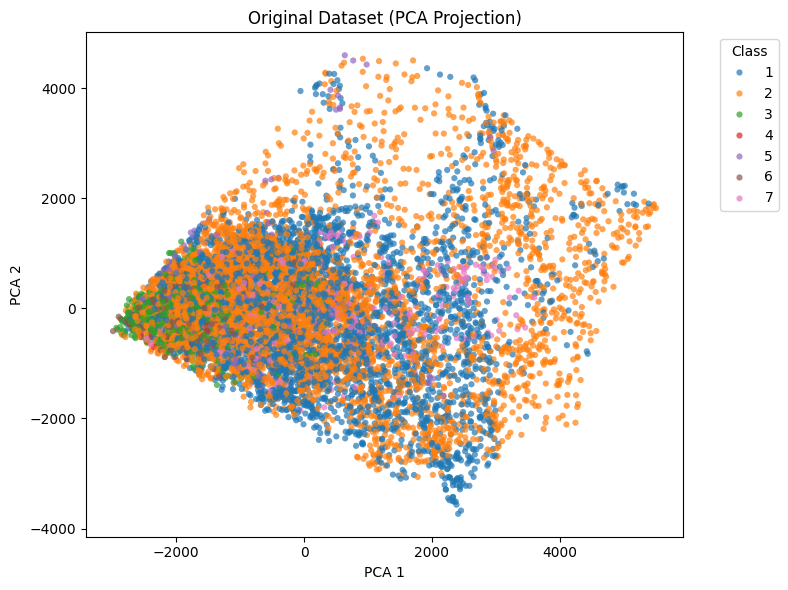

SMOTE + Tomek class distribution: Counter({np.int32(4): 4876, np.int32(6): 4873, np.int32(7): 4870, np.int32(3): 4870, np.int32(5): 4866, np.int32(1): 4664, np.int32(2): 4657})


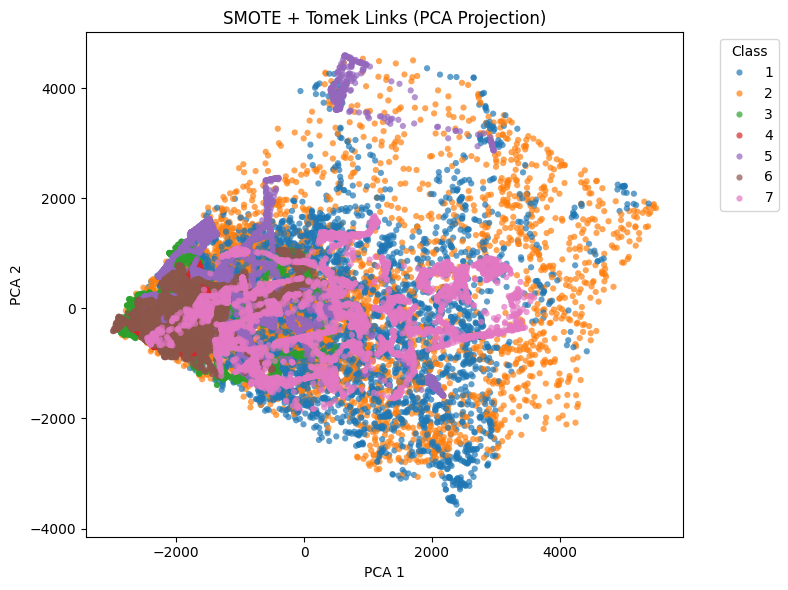

SMOTE + ENN class distribution: Counter({np.int32(4): 4871, np.int32(7): 4806, np.int32(6): 4796, np.int32(5): 4794, np.int32(3): 4756, np.int32(1): 3117, np.int32(2): 2466})


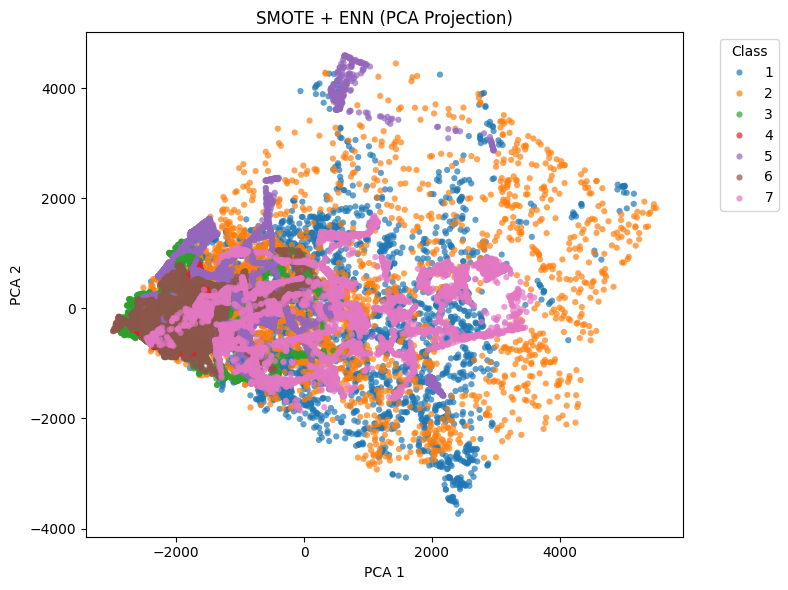

In [25]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
import seaborn as sns

# Load the Forest Cover dataset
X, y = fetch_covtype(return_X_y=True)

# Optional: Downsample for speed/visualization
from sklearn.model_selection import train_test_split
X_small, _, y_small, _ = train_test_split(X, y, train_size=10000, stratify=y, random_state=42)

# Reduce to 2D with PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_small)

# Helper: Plot function
def plot_pca(X_proj, y, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=y, palette='tab10', s=20, alpha=0.7, linewidth=0)
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Visualize original
plot_pca(X_pca, y_small, "Original Dataset (PCA Projection)")

# ---- SMOTE + Tomek ----
from imblearn.over_sampling import SMOTE
smote_tomek = SMOTETomek(random_state=42)
X_res_tomek, y_res_tomek = smote_tomek.fit_resample(X_small, y_small)
X_res_tomek_pca = pca.transform(X_res_tomek)
print("SMOTE + Tomek class distribution:", Counter(y_res_tomek))
plot_pca(X_res_tomek_pca, y_res_tomek, "SMOTE + Tomek Links (PCA Projection)")

# ---- SMOTE + ENN ----
smote_enn = SMOTEENN(random_state=42)
X_res_enn, y_res_enn = smote_enn.fit_resample(X_small, y_small)
X_res_enn_pca = pca.transform(X_res_enn)
print("SMOTE + ENN class distribution:", Counter(y_res_enn))
plot_pca(X_res_enn_pca, y_res_enn, "SMOTE + ENN (PCA Projection)")
